<h1 style="text-align:center;"><b>Laboratorio 3</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

## Librerias

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


## Importación de datos

In [ ]:
def cargar_modalidad_desde_nombre(path_mod):
    images = []
    labels = []
    for fname in sorted(os.listdir(path_mod)):
        if fname.endswith('.png'):
            label = int(fname.split('.')[1])
            img_path = os.path.join(path_mod, fname)
            img = Image.open(img_path).convert('RGB') 
            images.append(np.array(img))
            labels.append(label)
    return np.stack(images), np.array(labels)

In [ ]:
base_path = '/Users/arielamishaancohen/Documents/Datasets gigantes/MMNIST'
modalidades_train, modalidades_test = [], []

In [ ]:
for i in range(5):
    m_train, y_train = cargar_modalidad_desde_nombre(os.path.join(base_path, 'train', f'm{i}'))
    m_test, y_test = cargar_modalidad_desde_nombre(os.path.join(base_path, 'test', f'm{i}'))

    modalidades_train.append(m_train)
    modalidades_test.append(m_test)

print("Modalidades cargadas correctamente.")

Modalidades cargadas correctamente:
Modalidad 0: (60000, 28, 28)
Modalidad 1: (60000, 28, 28)
Modalidad 2: (60000, 28, 28)
Modalidad 3: (60000, 28, 28)
Modalidad 4: (60000, 28, 28)


In [ ]:
for i, mod in enumerate(modalidades_train):
    print(f'Modalidad {i}: {mod.shape}')
print()
for i, mod in enumerate(modalidades_test):
    print(f'Modalidad {i}: {mod.shape}')

## Análisis Exploratorio

### 1. Dimensiones y tipo de datos

In [ ]:
for i, mod in enumerate(modalidades_train):
    print(f"Modalidad {i} - shape: {mod.shape}, tipo: {mod.dtype}")
print(f"Etiquetas (y_train) - shape: {y_train.shape}, tipo: {y_train.dtype}")
print()
for i, mod in enumerate(modalidades_test):
    print(f"Modalidad {i} - shape: {mod.shape}, tipo: {mod.dtype}")
print(f"Etiquetas (y_test) - shape: {y_test.shape}, tipo: {y_test.dtype}")

Modalidad 0 - Train: (60000, 28, 28), tipo: uint8
Modalidad 1 - Train: (60000, 28, 28), tipo: uint8
Modalidad 2 - Train: (60000, 28, 28), tipo: uint8
Modalidad 3 - Train: (60000, 28, 28), tipo: uint8
Modalidad 4 - Train: (60000, 28, 28), tipo: uint8
y_train shape: (60000,), tipo: int64


Se puede ver que todas las imágenes tienen una dimensión de 28 x 28 pixeles. En cada modalidad del conjunto de entrenamiento hay 60 000 imágenes (300 000 imágenes de entrenamiento en total) y en cada modalidad de prueba hay 10 000 (50 000 imágenes de prueba)

### 2. Ejemplos y estadísticas básicas por modalidad

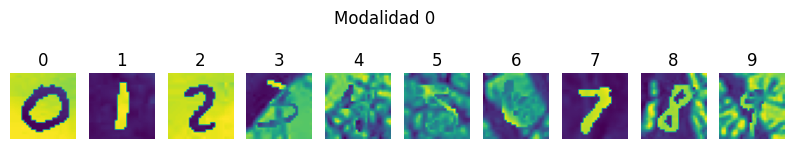

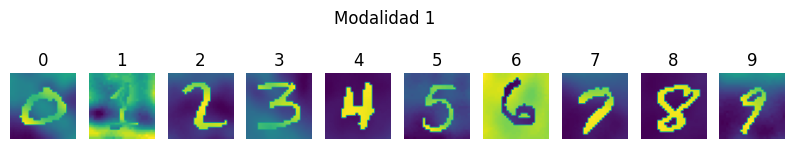

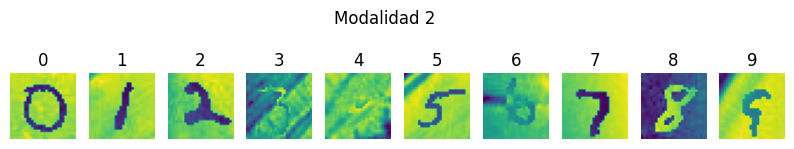

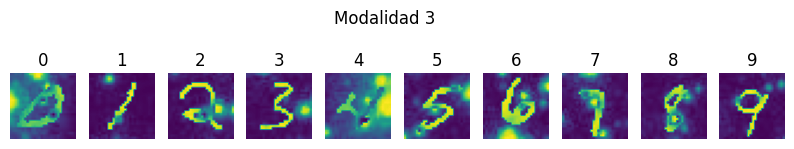

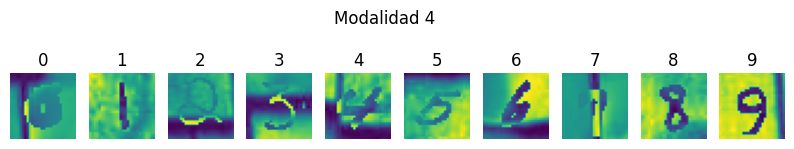

In [ ]:
for i in range(5):
    mod = modalidades_train[i]
    print(f"\nModalidad {i}:")
    print(f"  Mínimo: {mod.min()}")
    print(f"  Máximo: {mod.max()}")
    print(f"  Media: {mod.mean():.2f}")
    print(f"  Desviación estándar: {mod.std():.2f}")


In [ ]:
for i in range(5):
    mod = modalidades_test[i]
    print(f"\nModalidad {i}:")
    print(f"  Mínimo: {mod.min()}")
    print(f"  Máximo: {mod.max()}")
    print(f"  Media: {mod.mean():.2f}")
    print(f"  Desviación estándar: {mod.std():.2f}")

Se observa que las modalidades tienen una media parecida entre ellas al comparar entre train y test. La media indica que cada modalidad tiene un color aproximadamente distinto. 

### 3. Resolución e intensidad de imágenes

In [ ]:
alto, ancho = modalidades_train[0].shape[1:3]
print(f"Resolución de las imágenes: {alto} x {ancho}")

for i in range(5):
    plt.hist(modalidades_train[i].ravel(), bins=50, alpha=0.5, label=f'm{i}')
plt.title('Distribución de intensidades por modalidad')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Resolución de las imágenes: 28x28


### 4. Distribución y balanceo de clases

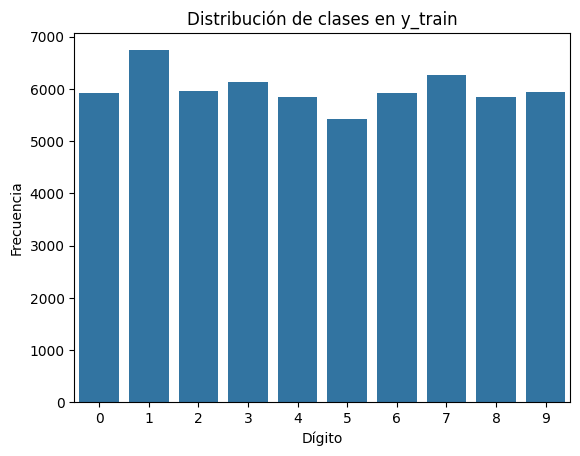

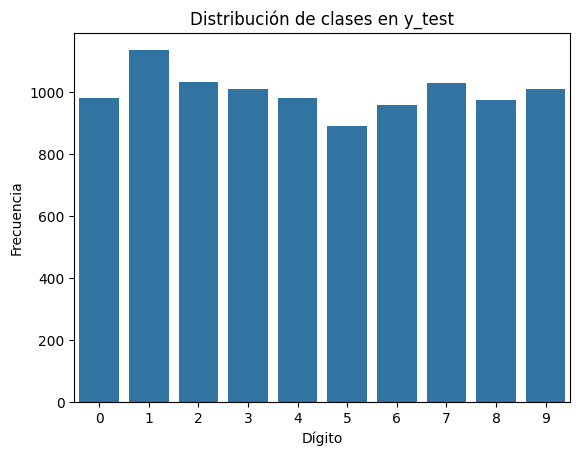

In [ ]:
# Train
df_train = pd.DataFrame({'label': y_train})
plt.figure(figsize=(8,4))
sns.countplot(data=df_train, x='label')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.show()

# Test
df_test = pd.DataFrame({'label': y_test})
plt.figure(figsize=(8,4))
sns.countplot(data=df_test, x='label')
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.show()

Como muestran las gráficas, las clases no están 100% balanceadas. La más frecuente es la 1 y la menos frecuente es la tanto en el conjunto de entrenamiento como en el de prueba. 

### 5. Ejemplos por modalidad y por clase

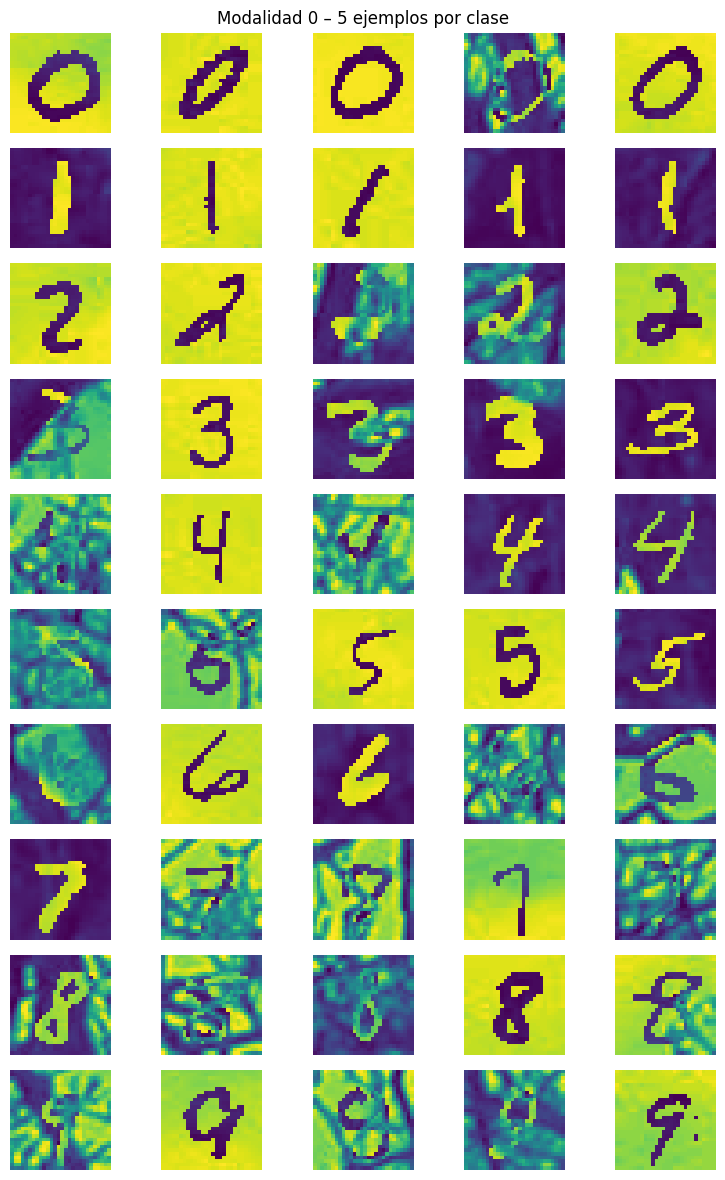

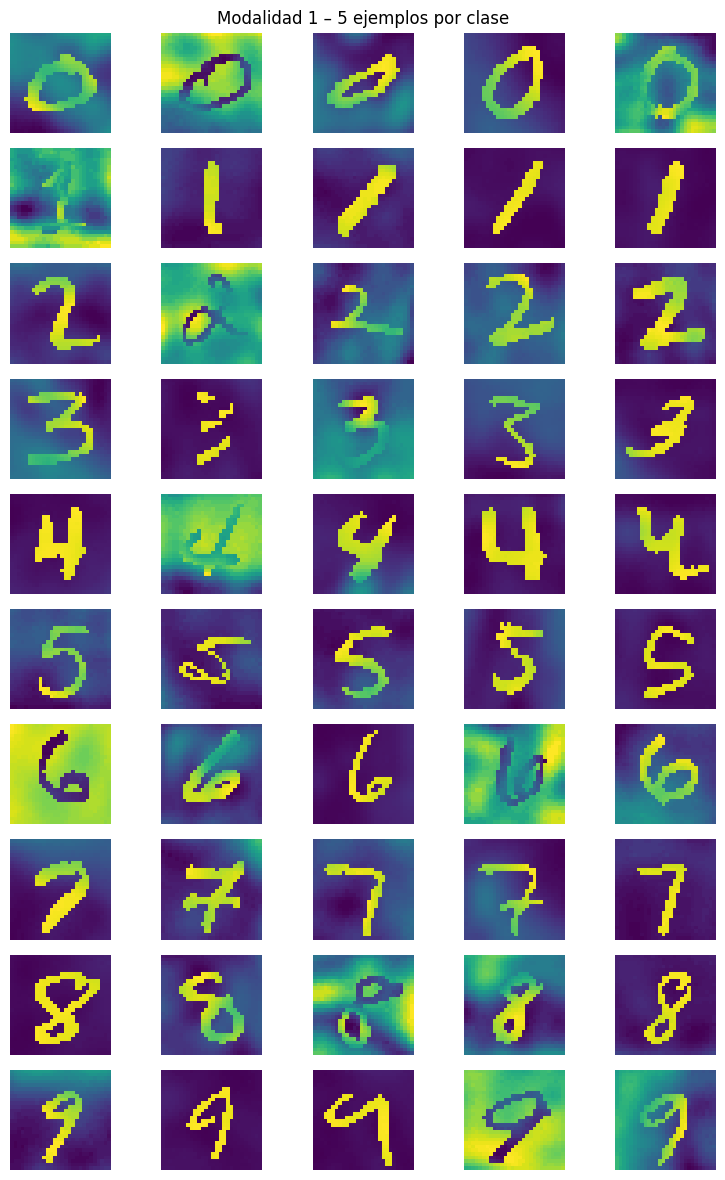

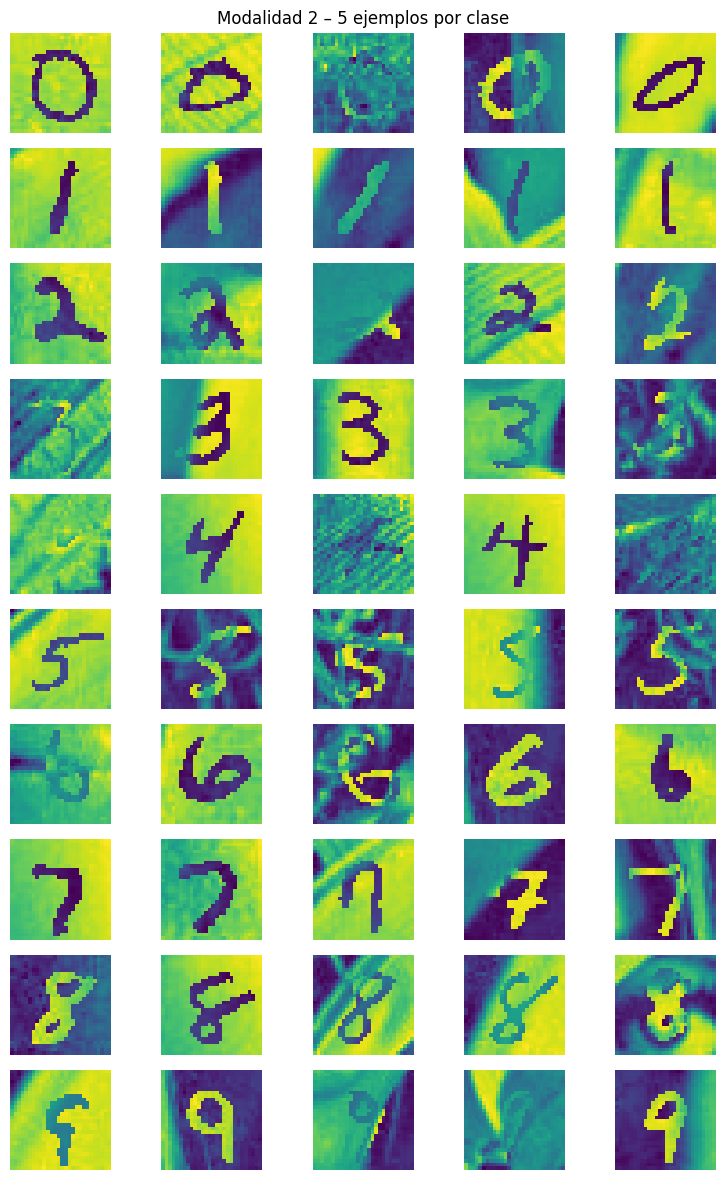

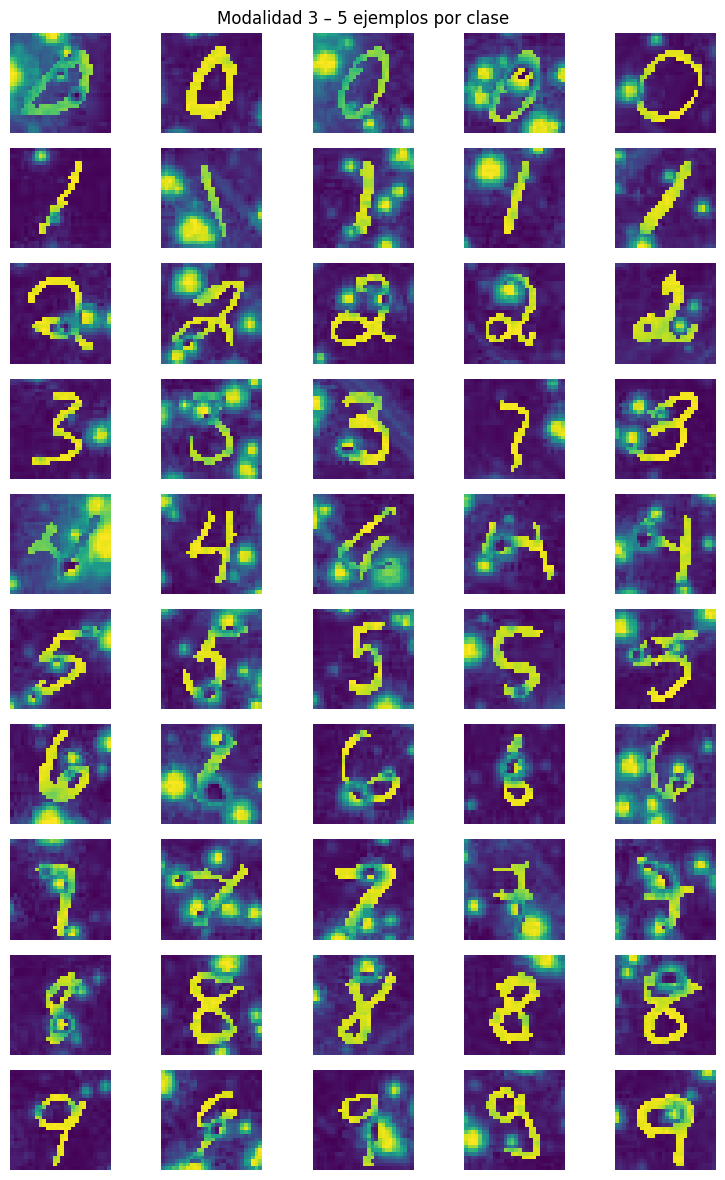

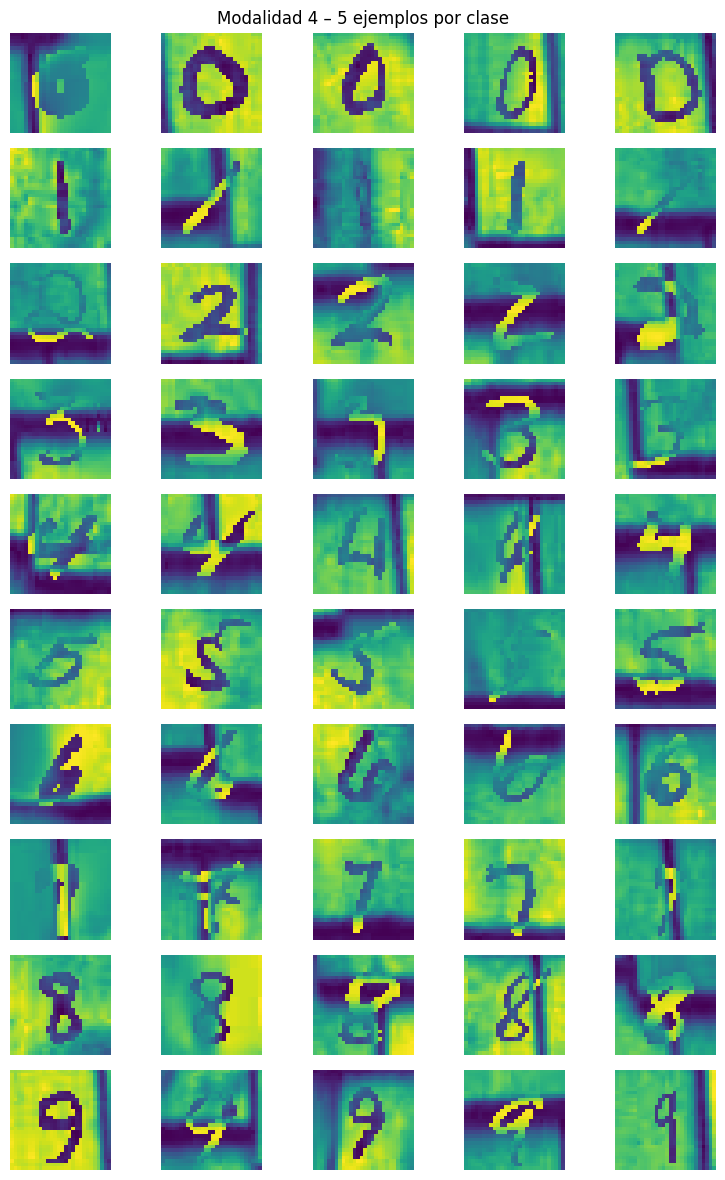

In [ ]:
for mod_idx in range(5):
    fig, axes = plt.subplots(10, 5, figsize=(8, 12))
    for digit in range(10):
        idxs = np.where(y_train == digit)[0][:5]
        for j, idx in enumerate(idxs):
            axes[digit, j].imshow(modalidades_train[mod_idx][idx])
            axes[digit, j].axis('off')
            if j == 0:
                axes[digit, j].set_ylabel(f'{digit}', fontsize=12)
    plt.suptitle(f'Modalidad {mod_idx} – 5 ejemplos por clase')
    plt.tight_layout()
    plt.show()


## Procesamiento de datos

Para realizar los modelos, primero se entrenaron con los datos como vienen. La segunda corrida se hizo con algunas modificaciones en las imágenes. Se probaron los filtros (en vez de RGB se intentó usar L, pero no fue efectivo), image augmentation, entre otros. Después de realizar las pruebas, las transformaciones que mantuvimos fueron:  

1. Concatenación de los datos: todas las modalidades del conjunto de entrenamiento se juntaron en una misma variable. Lo mismo se hizo con las de test. 
2. Normalización de imágenes por cada una de las modalidades. 
3. Expansión de etiquetas. 
4. Expansión de dimensiones (se expandió la dimensión de canal porque CNN espera shape [alto, ancho, canales]). 
5. Categorización de etiquetas

## Normalización

In [ ]:
# Normalización por modalidad
modalidades_train_norm = [mod.astype("float32") / 255.0 for mod in modalidades_train]
modalidades_test_norm = [mod.astype("float32") / 255.0 for mod in modalidades_test]

## Concatenar modalidades

In [ ]:
# Unimos todas las modalidades en un solo conjunto de entrenamiento y test
x_train = np.concatenate(modalidades_train_norm, axis=0)
x_test = np.concatenate(modalidades_test_norm, axis=0)

# Expandimos etiquetas (cada imagen aparece 5 veces)
y_train_ext = np.tile(y_train, 5)
y_test_ext = np.tile(y_test, 5)

print(x_train.shape, y_train_ext.shape)
print(x_test.shape, y_test_ext.shape)

## Expansión de dimensiones

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Shape final X_train:", x_train.shape)

## Categorización de etiquetas

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_ext, num_classes=10)
y_test_cat = to_categorical(y_test_ext, num_classes=10)

print("Shape etiquetas codificadas:", y_train_cat.shape)
print("x_train shape:", x_train.shape)  
print("y_train_cat shape:", y_train_cat.shape)


## Modelos CNN

### Modelo 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),  # ⬅️ 3 canales RGB
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model1.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history1 = model1.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=128,
    verbose=1
)

#### Gráficas modelo 1

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Modelo 1 – Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Modelo 1 – Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss1, test_acc1 = model1.evaluate(x_test, y_test_cat)
print(f"Precisión del Modelo 1 en test: {test_acc1:.4f}")

In [ ]:
model1.save("modelo_cnn1.h5")
print("Modelo guardado como modelo_cnn1.h5")

model1.save("modelo_cnn1.keras")
print("Modelo guardado como modelo_cnn1.keras")

## Modelo 2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, 
    restore_best_weights = True
)

history2 = model2.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=128,
    verbose=1, 
    callbacks = [early_stop]
)


Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.8135 - loss: 0.5606 - val_accuracy: 0.9747 - val_loss: 0.0770
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.9593 - loss: 0.1293 - val_accuracy: 0.9803 - val_loss: 0.0588
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - accuracy: 0.9695 - loss: 0.0959 - val_accuracy: 0.9829 - val_loss: 0.0550
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9744 - loss: 0.0812 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.9767 - loss: 0.0727 - val_accuracy: 0.9848 - val_loss: 0.0512
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9786 - loss: 0.0669 - val_accuracy: 0.9858 - val_loss: 0.0504
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9805 - loss: 0.0617 - val_accuracy: 0.9856 - val_loss: 0.0494
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.9815 -

### Gráficas modelo 2

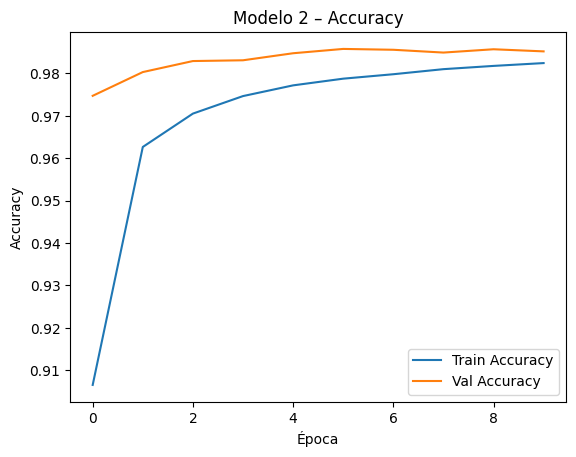

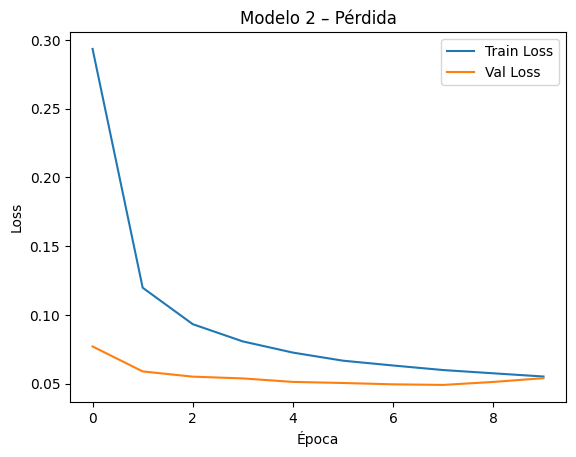

In [ ]:
# Accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Modelo 2 – Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Modelo 2 – Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss2, test_acc2 = model2.evaluate(x_test, y_test_cat)
print(f"Precisión del Modelo 2 en test: {test_acc2:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9847 - loss: 0.0503
Precisión del Modelo 2 en test: 0.9849


In [ ]:
model1.save("modelo_cnn2.h5")
print("Modelo guardado como modelo_cnn2.h5")

model1.save("modelo_cnn2.keras")
print("Modelo guardado como modelo_cnn2.keras")

Modelo guardado como modelo_cnn2.h5
Modelo guardado como modelo_cnn2.keras


# Otros modelos

## Modelo Boosted Stumps

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Aplanar imágenes RGB: (N, 28, 28, 3) → (N, 2352)
X_flat = x_train.reshape(len(x_train), -1)
X_test_flat = x_test.reshape(len(x_test), -1)

# Opcional: escalar (aunque no siempre necesario para árboles)
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Entrenar Boosted Stumps (max_depth=1 = stump)
bst = HistGradientBoostingClassifier(max_iter=100, max_depth=1, learning_rate=0.1)
bst.fit(X_flat_scaled, y_train_ext)



HistGradientBoostingClassifier(max_depth=1)

In [ ]:
# Evaluar
y_pred = bst.predict(X_test_scaled)
acc = accuracy_score(y_test_ext, y_pred)
print(f"Accuracy Boosted Stumps: {acc:.4f}")

Accuracy Boosted Stumps: 0.4696


In [ ]:
model1.save("modelo_boosted_stumps.h5")
print("Modelo guardado como modelo_boosted_stumps.h5")

model1.save("modelo_boosted_stumps.keras")
print("Modelo guardado como modelo_boosted_stumps.keras")

Modelo guardado como modelo_boosted_stumps.h5
Modelo guardado como modelo_boosted_stumps.keras
